In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def advanced_data_preprocessing(data):
    """
    Comprehensive data preprocessing pipeline

    Parameters:
    - data: Original DataFrame

    Returns:
    - Preprocessed DataFrame
    """
    # Select relevant columns
    relevant_columns = [
        'temperature', 'windspeed', 'humidity', 'precipitation',
        'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation',
        'sunshine_duration', 'ndvi', 'elevation'
    ]

    # Initial data cleaning
    cleaned_data = data[relevant_columns].copy()

    # Convert to numeric and handle errors
    cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')

    # Remove rows with NaN values
    cleaned_data = cleaned_data.dropna()

    # Additional preprocessing steps
    def additional_cleaning(df):
        # Remove extreme outliers (6 standard deviations)
        for column in df.columns:
            mean = df[column].mean()
            std = df[column].std()
            df = df[
                (df[column] >= mean - 6*std) &
                (df[column] <= mean + 6*std)
            ]
        return df

    cleaned_data = additional_cleaning(cleaned_data)

    # Descriptive statistics before and after cleaning
    print("\n--- Data Cleaning Summary ---")
    print(f"Original Data Rows: {len(data)}")
    print(f"Cleaned Data Rows: {len(cleaned_data)}")
    print(f"Rows Removed: {len(data) - len(cleaned_data)}")

    # Visualization of data distribution before and after cleaning
    def plot_distribution_comparison(original, cleaned, columns):
        plt.figure(figsize=(20, 15))
        for i, column in enumerate(columns, 1):
            plt.subplot(5, 4, i)
            plt.hist(original[column], bins=50, alpha=0.5, label='Original')
            plt.hist(cleaned[column], bins=50, alpha=0.5, label='Cleaned')
            plt.title(column)
            plt.legend()
        plt.tight_layout()
        plt.savefig('models/distribution_comparison.png')
        plt.close()

    # Ensure models directory exists
    os.makedirs("models", exist_ok=True)
    
    plot_distribution_comparison(data[relevant_columns], cleaned_data, relevant_columns)

    return cleaned_data

def find_optimal_dbscan_parameters(X_scaled, eps_range=(0.1, 1.0, 0.1), min_samples_range=(5, 50, 5)):
    """
    Find optimal DBSCAN parameters using silhouette score
    
    Parameters:
    - X_scaled: Scaled feature data
    - eps_range: Tuple of (start, end, step) for epsilon values
    - min_samples_range: Tuple of (start, end, step) for min_samples values
    
    Returns:
    - Dictionary with optimal parameters
    """
    best_score = -1
    best_params = {}
    results = []
    
    eps_values = np.arange(eps_range[0], eps_range[1] + eps_range[2], eps_range[2])
    min_samples_values = np.arange(min_samples_range[0], min_samples_range[1] + min_samples_range[2], min_samples_range[2])
    
    print("Finding optimal DBSCAN parameters...")
    print(f"Testing {len(eps_values)} epsilon values and {len(min_samples_values)} min_samples values")
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X_scaled)
                
                # Skip configurations with only noise points or a single cluster
                if len(np.unique(labels)) <= 1 or -1 not in np.unique(labels):
                    continue
                
                # Filter out noise points for silhouette calculation
                non_noise_points = X_scaled[labels != -1]
                non_noise_labels = labels[labels != -1]
                
                # Skip if there's not enough non-noise points
                if len(np.unique(non_noise_labels)) <= 1 or len(non_noise_points) < 10:
                    continue
                
                score = silhouette_score(non_noise_points, non_noise_labels)
                
                # Store results
                result_entry = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': len(np.unique(labels)) - (1 if -1 in labels else 0),
                    'noise_ratio': np.sum(labels == -1) / len(labels),
                    'silhouette': score
                }
                results.append(result_entry)
                
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    print(f"New best: eps={eps}, min_samples={min_samples}, score={score:.4f}, clusters={result_entry['n_clusters']}")
            except Exception as e:
                pass
    
    # Create a DataFrame from results and save
    if results:
        results_df = pd.DataFrame(results)
        results_df.to_csv('models/dbscan_parameter_search.csv', index=False)
        
        # Plot parameter search results
        plt.figure(figsize=(12, 10))
        
        # Plot silhouette scores
        plt.subplot(2, 1, 1)
        for min_samples in np.unique([r['min_samples'] for r in results]):
            subset = results_df[results_df['min_samples'] == min_samples]
            plt.plot(subset['eps'], subset['silhouette'], marker='o', label=f'min_samples={min_samples}')
        plt.xlabel('Epsilon')
        plt.ylabel('Silhouette Score')
        plt.title('DBSCAN Parameter Search: Silhouette Score')
        plt.legend()
        plt.grid(True)
        
        # Plot noise ratio
        plt.subplot(2, 1, 2)
        for min_samples in np.unique([r['min_samples'] for r in results]):
            subset = results_df[results_df['min_samples'] == min_samples]
            plt.plot(subset['eps'], subset['noise_ratio'], marker='o', label=f'min_samples={min_samples}')
        plt.xlabel('Epsilon')
        plt.ylabel('Noise Ratio')
        plt.title('DBSCAN Parameter Search: Noise Ratio')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('models/dbscan_parameter_search.png')
        plt.close()
    
    if best_params:
        print(f"Optimal parameters found: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
        return best_params
    else:
        print("Could not find optimal parameters. Using default values.")
        return {'eps': 0.5, 'min_samples': 5}

def visualize_clusters(X_scaled, labels, method='pca', title='DBSCAN Clustering'):
    """
    Visualize clusters using dimensionality reduction
    
    Parameters:
    - X_scaled: Scaled feature data
    - labels: Cluster labels from DBSCAN
    - method: Dimensionality reduction method ('pca' or 'tsne')
    - title: Plot title
    """
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")
    
    transformed = reducer.fit_transform(X_scaled)
    
    plt.figure(figsize=(12, 8))
    
    # Separate noise points from clusters
    noise_mask = labels == -1
    unique_labels = np.unique(labels)
    unique_clusters = [label for label in unique_labels if label != -1]
    
    # Plot noise points
    plt.scatter(
        transformed[noise_mask, 0],
        transformed[noise_mask, 1],
        color='black',
        marker='x',
        alpha=0.5,
        label='Noise'
    )
    
    # Plot clusters with different colors
    for cluster in unique_clusters:
        cluster_mask = labels == cluster
        plt.scatter(
            transformed[cluster_mask, 0],
            transformed[cluster_mask, 1],
            alpha=0.7,
            label=f'Cluster {cluster}'
        )
    
    plt.title(f'{title} ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'models/dbscan_clusters_{method}.png')
    plt.close()

def analyze_clusters(data, labels):
    """
    Analyze the characteristics of each cluster
    
    Parameters:
    - data: Original feature data (not scaled)
    - labels: Cluster labels from DBSCAN
    """
    # Create a new DataFrame with original data and cluster labels
    df_with_clusters = data.copy()
    df_with_clusters['cluster'] = labels
    
    # Calculate statistics for each cluster
    cluster_stats = []
    
    for cluster in sorted(df_with_clusters['cluster'].unique()):
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster]
        stats = {}
        stats['cluster'] = 'Noise' if cluster == -1 else f'Cluster {cluster}'
        stats['size'] = len(cluster_data)
        stats['size_percent'] = len(cluster_data) / len(df_with_clusters) * 100
        
        # Calculate mean and std for each feature
        for column in data.columns:
            stats[f'{column}_mean'] = cluster_data[column].mean()
            stats[f'{column}_std'] = cluster_data[column].std()
        
        cluster_stats.append(stats)
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(cluster_stats)
    stats_df.to_csv('models/cluster_statistics.csv', index=False)
    
    # Create radar plots for each cluster
    plot_cluster_profiles(data, labels)
    
    return stats_df

def plot_cluster_profiles(data, labels):
    """
    Create radar plots showing the profile of each cluster
    
    Parameters:
    - data: Original feature data (not scaled)
    - labels: Cluster labels from DBSCAN
    """
    df_with_clusters = data.copy()
    df_with_clusters['cluster'] = labels
    
    # Get feature names
    features = data.columns
    
    # Calculate global min and max for scaling
    min_vals = data.min()
    max_vals = data.max()
    
    # Plot each cluster (except noise)
    unique_clusters = sorted([c for c in np.unique(labels) if c != -1])
    
    if not unique_clusters:  # If only noise points
        print("No clusters found, only noise points.")
        return
    
    # Calculate number of rows and columns for subplots
    n_clusters = len(unique_clusters)
    n_cols = min(3, n_clusters)
    n_rows = (n_clusters + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(n_cols * 6, n_rows * 5))
    
    # Number of features/axes
    n_features = len(features)
    angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    for i, cluster in enumerate(unique_clusters, 1):
        ax = fig.add_subplot(n_rows, n_cols, i, polar=True)
        
        # Get cluster data
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster]
        
        # Calculate normalized means for the cluster
        means = []
        for feature in features:
            val = cluster_data[feature].mean()
            # Normalize between 0 and 1
            normalized = (val - min_vals[feature]) / (max_vals[feature] - min_vals[feature])
            means.append(normalized)
        
        # Close the loop
        means += means[:1]
        
        # Plot
        ax.plot(angles, means, 'o-', linewidth=2, label=f'Cluster {cluster}')
        ax.fill(angles, means, alpha=0.25)
        
        # Set labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features, fontsize=8)
        ax.set_title(f'Cluster {cluster} Profile (n={len(cluster_data)})')
        
        # Set y-ticks (0 to 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
        
    plt.tight_layout()
    plt.savefig('models/cluster_profiles.png')
    plt.close()

def assign_suitability_scores(feature_data, cluster_labels):
    """
    Assign suitability scores to clusters based on their characteristics
    
    Parameters:
    - feature_data: Original feature data
    - cluster_labels: Cluster labels from DBSCAN
    
    Returns:
    - DataFrame with suitability scores
    """
    # Create a DataFrame with original data and cluster labels
    df_with_clusters = feature_data.copy()
    df_with_clusters['cluster'] = cluster_labels
    
    # Dictionary to store cluster suitability scores
    cluster_scores = {}
    
    # Get unique clusters (excluding noise)
    unique_clusters = sorted([c for c in np.unique(cluster_labels) if c != -1])
    
    # Calculate cluster centroids
    centroids = {}
    for cluster in unique_clusters:
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster]
        centroids[cluster] = cluster_data.drop('cluster', axis=1).mean()
    
    # Define feature weights
    # You may need to adjust these weights based on domain knowledge
    feature_weights = {
        'temperature': 0.15,
        'windspeed': 0.10,
        'humidity': 0.10,
        'precipitation': 0.15,
        'dewpoint': 0.05,
        'cloud_cover': 0.05,
        'pressure': 0.05,
        'solar_radiation': 0.15,
        'sunshine_duration': 0.10,
        'ndvi': 0.05,
        'elevation': 0.05
    }
    
    # Define optimal values for each feature
    # These are example values - adjust based on your specific use case
    optimal_values = {
        'temperature': 25,  # Example: 25°C is optimal
        'windspeed': 10,    # Example: 10 km/h is optimal
        'humidity': 60,     # Example: 60% is optimal
        'precipitation': 5, # Example: 5mm daily is optimal
        'dewpoint': 15,     # Example: 15°C is optimal
        'cloud_cover': 30,  # Example: 30% is optimal
        'pressure': 1013,   # Example: 1013 hPa is optimal
        'solar_radiation': 800,  # Example: 800 W/m² is optimal
        'sunshine_duration': 8,  # Example: 8 hours is optimal
        'ndvi': 0.6,        # Example: 0.6 is optimal
        'elevation': 500    # Example: 500m is optimal
    }
    
    # Calculate scores for each cluster
    for cluster in unique_clusters:
        centroid = centroids[cluster]
        score = 0
        
        for feature, weight in feature_weights.items():
            optimal = optimal_values[feature]
            actual = centroid[feature]
            
            # Calculate normalized distance from optimal
            feature_min = feature_data[feature].min()
            feature_max = feature_data[feature].max()
            feature_range = feature_max - feature_min
            
            # Normalize the difference
            normalized_diff = abs(actual - optimal) / feature_range
            
            # Convert to a score (0 to 1, where 1 is perfect match)
            feature_score = 1 - min(normalized_diff, 1)
            
            # Apply weight
            score += feature_score * weight
        
        # Store the final score (0 to 100)
        cluster_scores[cluster] = score * 100
    
    # Create suitability categories
    def suitability_category(score):
        if score >= 80:
            return "Highly Suitable"
        elif score >= 60:
            return "Suitable"
        elif score >= 40:
            return "Moderately Suitable"
        elif score >= 20:
            return "Marginally Suitable"
        else:
            return "Not Suitable"
    
    # Create a DataFrame with scores
    scores_df = pd.DataFrame({
        'cluster': [f'Cluster {c}' for c in unique_clusters],
        'suitability_score': [cluster_scores[c] for c in unique_clusters]
    })
    
    # Add suitability category
    scores_df['suitability_category'] = scores_df['suitability_score'].apply(suitability_category)
    
    # Sort by score (descending)
    scores_df = scores_df.sort_values('suitability_score', ascending=False)
    
    # Save to CSV
    scores_df.to_csv('models/cluster_suitability_scores.csv', index=False)
    
    # Create a bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(scores_df['cluster'], scores_df['suitability_score'], color='skyblue')
    
    # Color bars based on category
    colors = {
        "Highly Suitable": "darkgreen",
        "Suitable": "green",
        "Moderately Suitable": "yellow",
        "Marginally Suitable": "orange",
        "Not Suitable": "red"
    }
    
    for i, bar in enumerate(bars):
        category = scores_df.iloc[i]['suitability_category']
        bar.set_color(colors[category])
    
    plt.xlabel('Cluster')
    plt.ylabel('Suitability Score (0-100)')
    plt.title('Cluster Suitability Scores')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    
    # Add a horizontal line at each category threshold
    plt.axhline(y=80, color='gray', linestyle='--', alpha=0.7)
    plt.axhline(y=60, color='gray', linestyle='--', alpha=0.7)
    plt.axhline(y=40, color='gray', linestyle='--', alpha=0.7)
    plt.axhline(y=20, color='gray', linestyle='--', alpha=0.7)
    
    # Add text labels for categories
    plt.text(len(unique_clusters)-1, 90, "Highly Suitable", ha='right', va='center')
    plt.text(len(unique_clusters)-1, 70, "Suitable", ha='right', va='center')
    plt.text(len(unique_clusters)-1, 50, "Moderately Suitable", ha='right', va='center')
    plt.text(len(unique_clusters)-1, 30, "Marginally Suitable", ha='right', va='center')
    plt.text(len(unique_clusters)-1, 10, "Not Suitable", ha='right', va='center')
    
    plt.tight_layout()
    plt.savefig('models/cluster_suitability_scores.png')
    plt.close()
    
    return scores_df

def train_dbscan_suitability_model(data):
    """
    Train a DBSCAN model for suitability analysis
    
    Parameters:
    - data: Full dataset
    
    Returns:
    - Dictionary with model results
    """
    try:
        # Ensure models directory exists
        os.makedirs("models", exist_ok=True)
        
        # Preprocess data
        feature_data = advanced_data_preprocessing(data)
        
        # Skip if insufficient data
        if len(feature_data) < 500:
            print("Insufficient data for DBSCAN model")
            return None
        
        # Scale the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(feature_data.values)
        
        # Find optimal DBSCAN parameters
        best_params = find_optimal_dbscan_parameters(X_scaled)
        
        # Create and fit DBSCAN model with optimal parameters
        dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
        labels = dbscan.fit_predict(X_scaled)
        
        # Visualize clusters
        visualize_clusters(X_scaled, labels, method='pca')
        visualize_clusters(X_scaled, labels, method='tsne')
        
        # Analyze clusters
        cluster_stats = analyze_clusters(feature_data, labels)
        
        # Assign suitability scores
        suitability_scores = assign_suitability_scores(feature_data, labels)
        
        # Save the model
        model_info = {
            'eps': best_params['eps'],
            'min_samples': best_params['min_samples'],
            'n_clusters': len(np.unique(labels)) - (1 if -1 in labels else 0),
            'noise_ratio': np.sum(labels == -1) / len(labels)
        }
        
        # Save model info
        with open('models/dbscan_model_info.pkl', 'wb') as f:
            pickle.dump(model_info, f)
        
        # Save scaler
        with open('models/dbscan_scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        
        print("DBSCAN model training complete.")
        print(f"Number of clusters: {model_info['n_clusters']}")
        print(f"Noise ratio: {model_info['noise_ratio']:.2f}")
        
        # Return model results
        return {
            'model_info': model_info,
            'scaler': scaler,
            'labels': labels,
            'cluster_stats': cluster_stats,
            'suitability_scores': suitability_scores
        }
        
    except Exception as e:
        print(f"Error training DBSCAN model: {e}")
        return None

def classify_new_data(new_data, model_folder='models'):
    """
    Classify new data using the trained DBSCAN model
    
    Parameters:
    - new_data: New data to classify
    - model_folder: Path to folder containing model files
    
    Returns:
    - DataFrame with classification results
    """
    try:
        # Load scaler
        with open(f'{model_folder}/dbscan_scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        
        # Load model info
        with open(f'{model_folder}/dbscan_model_info.pkl', 'rb') as f:
            model_info = pickle.load(f)
        
        # Load suitability scores
        suitability_df = pd.read_csv(f'{model_folder}/cluster_suitability_scores.csv')
        
        # Preprocess new data
        relevant_columns = [
            'temperature', 'windspeed', 'humidity', 'precipitation',
            'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation',
            'sunshine_duration', 'ndvi', 'elevation'
        ]
        
        # Check if all required columns are present
        missing_columns = [col for col in relevant_columns if col not in new_data.columns]
        if missing_columns:
            print(f"Error: Missing columns in new data: {missing_columns}")
            return None
        
        # Extract relevant features
        feature_data = new_data[relevant_columns].copy()
        
        # Handle missing values
        feature_data = feature_data.dropna()
        if len(feature_data) == 0:
            print("Error: No valid data after removing missing values")
            return None
        
        # Scale the data
        X_scaled = scaler.transform(feature_data.values)
        
        # Create a new DBSCAN model with the same parameters
        dbscan = DBSCAN(eps=model_info['eps'], min_samples=model_info['min_samples'])
        
        # Predict clusters
        labels = dbscan.fit_predict(X_scaled)
        
        # Create results DataFrame
        results = feature_data.copy()
        results['cluster'] = labels
        
        # Map clusters to suitability scores
        suitability_map = {}
        for _, row in suitability_df.iterrows():
            cluster_num = int(row['cluster'].split(' ')[1])
            suitability_map[cluster_num] = {
                'score': row['suitability_score'],
                'category': row['suitability_category']
            }
        
        # Add suitability information
        def get_suitability(cluster):
            if cluster == -1:
                return {'score': 0, 'category': 'Noise (Unclassified)'}
            elif cluster in suitability_map:
                return suitability_map[cluster]
            else:
                return {'score': 0, 'category': 'Unknown Cluster'}
        
        results['suitability_score'] = results['cluster'].apply(lambda x: get_suitability(x)['score'])
        results['suitability_category'] = results['cluster'].apply(lambda x: get_suitability(x)['category'])
        
        return results
        
    except Exception as e:
        print(f"Error classifying new data: {e}")
        return None

def main():
    """
    Train a DBSCAN model for suitability analysis
    
    Returns:
    - Trained DBSCAN model
    """
    # Load your dataset
    df = pd.read_excel("../og.xlsx")
    
    # Remove rows with any empty values
    df = df.dropna()
    
    # Train DBSCAN model
    dbscan_model = train_dbscan_suitability_model(df)
    
    return dbscan_model

if __name__ == "__main__":
    main()


--- Data Cleaning Summary ---
Original Data Rows: 19275
Cleaned Data Rows: 19188
Rows Removed: 87
Finding optimal DBSCAN parameters...
Testing 10 epsilon values and 10 min_samples values
New best: eps=0.1, min_samples=5, score=0.7232, clusters=776
New best: eps=0.1, min_samples=10, score=0.7508, clusters=456
New best: eps=0.1, min_samples=15, score=0.7785, clusters=318
New best: eps=0.1, min_samples=20, score=0.7997, clusters=220
New best: eps=0.1, min_samples=25, score=0.8145, clusters=166
New best: eps=0.1, min_samples=30, score=0.8189, clusters=125
New best: eps=0.1, min_samples=35, score=0.8443, clusters=99
New best: eps=0.1, min_samples=40, score=0.8509, clusters=77
Optimal parameters found: eps=0.1, min_samples=40


C:\Users\visha\AppData\Local\Temp\ipykernel_19312\1596696684.py:319: RuntimeWarning: invalid value encountered in scalar divide
  normalized = (val - min_vals[feature]) / (max_vals[feature] - min_vals[feature])
C:\Users\visha\AppData\Local\Temp\ipykernel_19312\1596696684.py:319: RuntimeWarning: invalid value encountered in scalar divide
  normalized = (val - min_vals[feature]) / (max_vals[feature] - min_vals[feature])
C:\Users\visha\AppData\Local\Temp\ipykernel_19312\1596696684.py:319: RuntimeWarning: invalid value encountered in scalar divide
  normalized = (val - min_vals[feature]) / (max_vals[feature] - min_vals[feature])
C:\Users\visha\AppData\Local\Temp\ipykernel_19312\1596696684.py:319: RuntimeWarning: invalid value encountered in scalar divide
  normalized = (val - min_vals[feature]) / (max_vals[feature] - min_vals[feature])
C:\Users\visha\AppData\Local\Temp\ipykernel_19312\1596696684.py:319: RuntimeWarning: invalid value encountered in scalar divide
  normalized = (val - min_va

DBSCAN model training complete.
Number of clusters: 77
Noise ratio: 0.75


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from kneed import KneeLocator

def advanced_data_preprocessing(data):
    """
    Comprehensive data preprocessing pipeline for weather/habitat data
    
    Parameters:
    - data: Original DataFrame
    
    Returns:
    - Preprocessed DataFrame
    """
    relevant_columns = [
        'temperature', 'windspeed', 'humidity', 'precipitation',
        'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation',
        'sunshine_duration', 'ndvi', 'elevation'
    ]
    
    # Initial cleaning
    cleaned_data = data[relevant_columns].copy()
    cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')
    cleaned_data = cleaned_data.dropna()
    
    # Advanced outlier removal using IQR
    def remove_outliers(df):
        for col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
        return df
    
    cleaned_data = remove_outliers(cleaned_data)
    
    # Log-transform skewed features
    skewed_features = ['precipitation', 'solar_radiation', 'sunshine_duration']
    for feat in skewed_features:
        if feat in cleaned_data.columns:
            cleaned_data[feat] = np.log1p(cleaned_data[feat])
    
    print(f"\nData cleaning summary:")
    print(f"Original samples: {len(data)}")
    print(f"Clean samples: {len(cleaned_data)}")
    print(f"Features used: {len(relevant_columns)}")
    
    return cleaned_data

def find_optimal_kmeans_clusters(X_scaled, max_clusters=10):
    """
    Find optimal number of K-means clusters using the elbow method and silhouette scores
    
    Parameters:
    - X_scaled: Scaled feature data
    - max_clusters: Maximum number of clusters to test
    
    Returns:
    - optimal_k: Optimal number of clusters
    """
    # Limit max clusters based on data size
    max_clusters = min(max_clusters, X_scaled.shape[0] // 10)
    max_clusters = max(max_clusters, 2)  # Ensure at least 2 clusters
    
    # Calculate inertia and silhouette scores for different k values
    inertia = []
    silhouette_scores = []
    k_values = range(2, max_clusters + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    # Plot elbow curve
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertia, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.grid(True)
    
    # Try to find elbow point automatically
    try:
        kneedle = KneeLocator(list(k_values), inertia, curve='convex', direction='decreasing')
        elbow_k = kneedle.elbow
        if elbow_k:
            plt.axvline(x=elbow_k, color='r', linestyle='--', label=f'Elbow at k={elbow_k}')
            plt.legend()
    except:
        elbow_k = None
        pass
    
    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.grid(True)
    
    # Mark best silhouette score
    best_k_silhouette = k_values[np.argmax(silhouette_scores)]
    plt.axvline(x=best_k_silhouette, color='g', linestyle='--', 
                label=f'Best at k={best_k_silhouette}')
    plt.legend()
    
    plt.tight_layout()
    os.makedirs('models', exist_ok=True)
    plt.savefig('models/kmeans_elbow_method.png')
    plt.close()
    
    # Find optimal k using silhouette score
    optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
    
    # Choose the optimal k (prioritize silhouette score method)
    optimal_k = optimal_k_silhouette
    if elbow_k and elbow_k != optimal_k_silhouette:
        print(f"\nNote: Elbow method suggests {elbow_k} clusters, while silhouette score suggests {optimal_k_silhouette}.")
        print(f"Using silhouette score's suggestion ({optimal_k_silhouette}) for better cluster separation.")
    
    print(f"\nK-means parameter selection:")
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Best silhouette score: {max(silhouette_scores):.3f}")
    
    return optimal_k

def train_kmeans_model(X_scaled, n_clusters):
    """
    Train KMeans clustering model
    
    Parameters:
    - X_scaled: Scaled feature data
    - n_clusters: Number of clusters
    
    Returns:
    - KMeans model and cluster labels
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Evaluate clustering
    silhouette = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    print(f"\nClustering quality metrics:")
    print(f"Silhouette score: {silhouette:.3f} (higher is better)")
    print(f"Davies-Bouldin score: {db_score:.3f} (lower is better)")
    
    return kmeans, labels

def visualize_clusters(X_scaled, labels, method='pca'):
    """
    Visualize clusters using dimensionality reduction
    
    Parameters:
    - X_scaled: Scaled feature data
    - labels: Cluster labels
    - method: 'pca' or 'tsne'
    """
    if method == 'pca':
        reducer = PCA(n_components=2)
        title = "PCA Projection"
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
        title = "t-SNE Projection"
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    # Reduce dimensions
    projected = reducer.fit_transform(X_scaled)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Get unique clusters
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # Use perceptually uniform colormap
    colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
    
    for i, label in enumerate(unique_labels):
        color = colors[i]
        alpha = 0.7
        size = 30
        legend_label = f'Cluster {label}'
        
        mask = labels == label
        plt.scatter(
            projected[mask, 0], projected[mask, 1],
            c=[color],
            s=size,
            alpha=alpha,
            label=legend_label
        )
    
    plt.title(f'{title} of KMeans Clustering\n({n_clusters} clusters found)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    # Save figure
    os.makedirs('models', exist_ok=True)
    plt.savefig(f'models/kmeans_clusters_{method}.png', bbox_inches='tight')
    plt.close()

def analyze_clusters(feature_data, labels):
    """
    Analyze cluster characteristics and generate reports
    
    Parameters:
    - feature_data: Original feature data (not scaled)
    - labels: Cluster labels
    
    Returns:
    - DataFrame with cluster statistics
    """
    df = feature_data.copy()
    df['Cluster'] = labels
    
    # Calculate statistics
    cluster_stats = []
    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster]
        stats = {
            'cluster': cluster,
            'size': len(cluster_data),
            'size_pct': len(cluster_data)/len(df)*100
        }
        
        # Add feature statistics
        for col in feature_data.columns:
            stats[f'{col}_mean'] = cluster_data[col].mean()
            stats[f'{col}_std'] = cluster_data[col].std()
        
        cluster_stats.append(stats)
    
    # Create DataFrame
    stats_df = pd.DataFrame(cluster_stats)
    
    # Save to CSV
    stats_df.to_csv('models/cluster_statistics.csv', index=False)
    
    # Generate radar plots
    plot_cluster_profiles(df)
    
    return stats_df

def plot_cluster_profiles(df):
    """
    Create radar plots showing cluster characteristics
    
    Parameters:
    - df: DataFrame with features and 'Cluster' column
    """
    # Normalize features for radar plot
    features = [col for col in df.columns if col != 'Cluster']
    normalized = df[features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    normalized['Cluster'] = df['Cluster']
    
    # Prepare data for plotting
    clusters = sorted(normalized['Cluster'].unique())
    n_features = len(features)
    angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(clusters), figsize=(5*len(clusters), 5),
                            subplot_kw={'polar': True})
    if len(clusters) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    for i, (ax, cluster) in enumerate(zip(axes, clusters)):
        # Get data for current cluster
        cluster_data = normalized[normalized['Cluster'] == cluster][features]
        values = cluster_data.mean().values.tolist()
        values += values[:1]  # Close the loop
        
        # Plot
        ax.plot(angles, values, 'o-', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
        
        # Format
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features, fontsize=8)
        ax.set_title(f'Cluster {cluster}', size=12, pad=10)
        ax.set_rlabel_position(30)
    
    plt.tight_layout()
    plt.savefig('models/cluster_profiles.png')
    plt.close()

def assign_suitability_scores(feature_data, labels):
    """
    Assign habitat suitability scores to clusters based on feature distributions
    
    Parameters:
    - feature_data: Original feature data
    - labels: Cluster labels
    
    Returns:
    - DataFrame with suitability scores
    """
    # Calculate cluster centroids
    df = feature_data.copy()
    df['Cluster'] = labels
    centroids = df.groupby('Cluster').mean()
    
    # Use data distribution to determine suitable ranges
    # Higher score = more central/typical values in the distribution
    scores = []
    for cluster, centroid in centroids.iterrows():
        # Calculate how central this cluster's values are across all features
        score = 0
        for feature in feature_data.columns:
            # Calculate normalized distance from the overall mean
            feature_mean = feature_data[feature].mean()
            feature_std = feature_data[feature].std()
            
            # How many standard deviations from the mean?
            if feature_std > 0:  # Avoid division by zero
                z_score = abs(centroid[feature] - feature_mean) / feature_std
                # Convert to a 0-1 score (closer to mean = higher score)
                feature_score = np.exp(-z_score)  # Exponential decay with distance
            else:
                feature_score = 1.0  # If no variation, give full score
                
            # Add to total score (equal weight for all features)
            score += feature_score / len(feature_data.columns)
        
        # Scale to 0-100
        final_score = score * 100
        scores.append({
            'cluster': cluster,
            'score': final_score,
            'size': len(df[df['Cluster'] == cluster])
        })
    
    # Create DataFrame
    scores_df = pd.DataFrame(scores)
    
    # Add suitability category
    def get_category(score):
        if score >= 80: return "Excellent"
        elif score >= 60: return "Good"
        elif score >= 40: return "Moderate"
        elif score >= 20: return "Marginal"
        else: return "Unsuitable"
    
    scores_df['category'] = scores_df['score'].apply(get_category)
    scores_df = scores_df.sort_values('score', ascending=False)
    
    # Save and plot
    scores_df.to_csv('models/suitability_scores.csv', index=False)
    
    plt.figure(figsize=(10, 6))
    palette = {'Excellent': 'green', 'Good': 'limegreen', 
               'Moderate': 'gold', 'Marginal': 'orange',
               'Unsuitable': 'red'}
    
    sns.barplot(data=scores_df, x='cluster', y='score', 
                hue='category', dodge=False, palette=palette)
    plt.title('Habitat Suitability Scores by Cluster')
    plt.xlabel('Cluster ID')
    plt.ylabel('Suitability Score (0-100)')
    plt.ylim(0, 100)
    plt.legend(title='Suitability')
    plt.savefig('models/suitability_scores.png')
    plt.close()
    
    return scores_df

def main():
    """Main workflow for habitat suitability analysis"""
    # Load data
    data = pd.read_excel("../og.xlsx")  # Update with your path
    print(f"Data loaded with {len(data)} records")
    
    # Preprocess
    feature_data = advanced_data_preprocessing(data)
    if len(feature_data) < 10:  # Reduced minimum requirement
        raise ValueError("Insufficient data after preprocessing")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(feature_data)
    
    # Find optimal number of clusters
    optimal_k = find_optimal_kmeans_clusters(X_scaled)
    
    # Train KMeans model
    kmeans_model, labels = train_kmeans_model(X_scaled, optimal_k)
    
    # Visualize
    visualize_clusters(X_scaled, labels, 'pca')
    visualize_clusters(X_scaled, labels, 'tsne')
    
    # Analyze
    cluster_stats = analyze_clusters(feature_data, labels)
    suitability_scores = assign_suitability_scores(feature_data, labels)
    
    # Save model
    with open('models/kmeans_model.pkl', 'wb') as f:
        pickle.dump({
            'model': kmeans_model,
            'scaler': scaler,
            'n_clusters': optimal_k,
            'labels': labels
        }, f)
    
    print("\nAnalysis complete!")
    print(f"Found {len(np.unique(labels))} habitat clusters")
    print("Results saved in 'models/' directory")

if __name__ == "__main__":
    main()

Data loaded with 19275 records

Data cleaning summary:
Original samples: 19275
Clean samples: 14739
Features used: 11

Note: Elbow method suggests 5 clusters, while silhouette score suggests 2.
Using silhouette score's suggestion (2) for better cluster separation.

K-means parameter selection:
Optimal number of clusters: 2
Best silhouette score: 0.391

Clustering quality metrics:
Silhouette score: 0.391 (higher is better)
Davies-Bouldin score: 1.147 (lower is better)


In [4]:
import pandas as pd
from sklearn.cluster import DBSCAN
import pickle

# Load your new data that needs classification
new_data = pd.read_excel("../og.xlsx")  # Replace with your actual file path

# Call the classify_new_data function
results = classify_new_data(new_data)

# View the results
if results is not None:
    print(f"Classification complete. Found {len(results)} valid data points.")
    print("\nSuitability distribution:")
    print(results['suitability_category'].value_counts())
    
    # Display a sample of the results
    print("\nSample results:")
    print(results[['cluster', 'suitability_score', 'suitability_category']].head())
    
    # Optional: Save the results to a file
    results.to_excel("classification_results.xlsx", index=False)
    print("\nResults saved to 'classification_results.xlsx'")

Classification complete. Found 19275 valid data points.

Suitability distribution:
suitability_category
Noise (Unclassified)    14507
Moderately Suitable      3297
Marginally Suitable      1425
Suitable                   46
Name: count, dtype: int64

Sample results:
   cluster  suitability_score  suitability_category
0       -1           0.000000  Noise (Unclassified)
1       -1           0.000000  Noise (Unclassified)
2       -1           0.000000  Noise (Unclassified)
3       -1           0.000000  Noise (Unclassified)
4        4          56.782963   Moderately Suitable

Results saved to 'classification_results.xlsx'


In [1]:
import pandas as pd
import numpy as np
import pickle
import os

def classify_new_data(new_data_path, model_path='models/optics_model.pkl'):
    """
    Classify new data using a previously trained OPTICS model
    
    Parameters:
    - new_data_path: Path to new data file (Excel or CSV)
    - model_path: Path to saved OPTICS model
    
    Returns:
    - DataFrame with original data and cluster assignments
    """
    # Load the model and related objects
    print("Loading OPTICS model...")
    with open(model_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    optics_model = saved_data['model']
    scaler = saved_data['scaler']
    params = saved_data['params']
    
    print(f"Model loaded successfully with parameters: {params}")
    
    # Load new data
    if new_data_path.endswith('.xlsx') or new_data_path.endswith('.xls'):
        data = pd.read_excel(new_data_path)
    elif new_data_path.endswith('.csv'):
        data = pd.read_csv(new_data_path)
    else:
        raise ValueError("Unsupported file format. Please use Excel or CSV.")
    
    print(f"Loaded new data with {len(data)} records")
    
    # Extract relevant features (must match the features used in training)
    relevant_columns = [
        'temperature', 'windspeed', 'humidity', 'precipitation',
        'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation',
        'sunshine_duration', 'ndvi', 'elevation'
    ]
    
    # Check if all required columns exist
    missing_cols = [col for col in relevant_columns if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in new data: {missing_cols}")
    
    # Preprocess new data (similar to training preprocessing)
    feature_data = data[relevant_columns].copy()
    feature_data = feature_data.apply(pd.to_numeric, errors='coerce')
    
    # Handle missing values
    if feature_data.isnull().any().any():
        print(f"Warning: Found {feature_data.isnull().sum().sum()} missing values. Filling with medians.")
        feature_data = feature_data.fillna(feature_data.median())
    
    # Apply same log transformations as during training
    skewed_features = ['precipitation', 'solar_radiation', 'sunshine_duration']
    for feat in skewed_features:
        if feat in feature_data.columns:
            feature_data[feat] = np.log1p(feature_data[feat])
    
    # Scale features using the same scaler
    X_scaled = scaler.transform(feature_data)
    
    # Predict clusters
    print("Predicting clusters...")
    labels = optics_model.fit_predict(X_scaled)
    
    # Add cluster labels to original data
    result_df = data.copy()
    result_df['Cluster'] = labels
    
    # Count samples per cluster
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    print("\nCluster distribution:")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.1f}%)")
    
    # Save results
    os.makedirs('results', exist_ok=True)
    output_path = 'results/classified_data.csv'
    result_df.to_csv(output_path, index=False)
    print(f"\nResults saved to {output_path}")
    
    return result_df

def get_suitability_scores(classified_df, suitability_scores_path='models/suitability_scores.csv'):
    """
    Add habitat suitability scores to classified data
    
    Parameters:
    - classified_df: DataFrame with cluster assignments
    - suitability_scores_path: Path to saved suitability scores
    
    Returns:
    - DataFrame with suitability scores added
    """
    # Check if suitability scores exist
    if not os.path.exists(suitability_scores_path):
        print("Suitability scores file not found. Cannot assign suitability categories.")
        return classified_df
    
    # Load suitability scores
    scores_df = pd.read_csv(suitability_scores_path)
    
    # Create mapping dictionaries
    score_map = dict(zip(scores_df['cluster'], scores_df['score']))
    category_map = dict(zip(scores_df['cluster'], scores_df['category']))
    
    # Add scores and categories to results
    result_df = classified_df.copy()
    result_df['Suitability_Score'] = result_df['Cluster'].map(score_map)
    result_df['Suitability_Category'] = result_df['Cluster'].map(category_map)
    
    # Handle noise points (cluster -1)
    if -1 in result_df['Cluster'].values and -1 not in score_map:
        result_df.loc[result_df['Cluster'] == -1, 'Suitability_Score'] = 0
        result_df.loc[result_df['Cluster'] == -1, 'Suitability_Category'] = 'Unknown (Noise)'
    
    # Save enhanced results
    output_path = 'results/classified_data_with_suitability.csv'
    result_df.to_csv(output_path, index=False)
    print(f"Results with suitability scores saved to {output_path}")
    
    return result_df

import pandas as pd
import numpy as np
import pickle
import os
from collections import defaultdict

def classify_grouped_data(new_data_path, model_path='models/optics_model.pkl'):
    """
    Classify new data using a previously trained OPTICS model,
    with grouping by latitude, longitude, and month
    
    Parameters:
    - new_data_path: Path to new data file (Excel or CSV)
    - model_path: Path to saved OPTICS model
    
    Returns:
    - DataFrame with original data and cluster assignments
    - Summary DataFrame with results grouped by location and month
    """
    # Load the model and related objects
    print("Loading OPTICS model...")
    with open(model_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    optics_model = saved_data['model']
    scaler = saved_data['scaler']
    params = saved_data['params']
    
    print(f"Model loaded successfully with parameters: {params}")
    
    # Load new data
    if new_data_path.endswith('.xlsx') or new_data_path.endswith('.xls'):
        data = pd.read_excel(new_data_path)
    elif new_data_path.endswith('.csv'):
        data = pd.read_csv(new_data_path)
    else:
        raise ValueError("Unsupported file format. Please use Excel or CSV.")
    
    print(f"Loaded new data with {len(data)} records")
    
    # Extract relevant features (must match the features used in training)
    relevant_columns = [
        'temperature', 'windspeed', 'humidity', 'precipitation',
        'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation',
        'sunshine_duration', 'ndvi', 'elevation'
    ]
    
    # Check if all required columns exist
    missing_cols = [col for col in relevant_columns if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in new data: {missing_cols}")
    
    # Group data by latitude, longitude, and month
    location_groups = data.groupby(['latitude', 'longitude', 'month'])
    
    # Create a dictionary to store results for each group
    group_results = defaultdict(list)
    
    # Process each group separately
    all_classified_data = []
    
    print(f"\nProcessing {len(location_groups)} unique location-month combinations...")
    
    for (lat, lon, month), group_data in location_groups:
        print(f"\nProcessing: Latitude={lat}, Longitude={lon}, Month={month}")
        print(f"  Group size: {len(group_data)} records")
        
        # Extract features
        feature_data = group_data[relevant_columns].copy()
        feature_data = feature_data.apply(pd.to_numeric, errors='coerce')
        
        # Handle missing values
        if feature_data.isnull().any().any():
            print(f"  Warning: Found {feature_data.isnull().sum().sum()} missing values. Filling with medians.")
            feature_data = feature_data.fillna(feature_data.median())
        
        # Apply same log transformations as during training
        skewed_features = ['precipitation', 'solar_radiation', 'sunshine_duration']
        for feat in skewed_features:
            if feat in feature_data.columns:
                feature_data[feat] = np.log1p(feature_data[feat])
        
        # Scale features using the same scaler
        X_scaled = scaler.transform(feature_data)
        
        # Predict clusters for this group
        labels = optics_model.fit_predict(X_scaled)
        
        # Add cluster labels to original group data
        group_result = group_data.copy()
        group_result['Cluster'] = labels
        
        # Count occurrences of each cluster in this group
        cluster_counts = pd.Series(labels).value_counts()
        
        # Find the most common cluster (dominant cluster)
        if len(cluster_counts) > 0:
            dominant_cluster = cluster_counts.idxmax()
            dominant_count = cluster_counts.max()
            dominant_pct = (dominant_count / len(labels)) * 100
        else:
            dominant_cluster = -1
            dominant_count = 0
            dominant_pct = 0
        
        # Store group summary
        group_summary = {
            'latitude': lat,
            'longitude': lon,
            'month': month,
            'records': len(group_data),
            'dominant_cluster': dominant_cluster,
            'dominant_cluster_count': dominant_count,
            'dominant_cluster_pct': dominant_pct,
            'unique_clusters': len(cluster_counts)
        }
        
        # Store results
        group_results['latitude'].append(lat)
        group_results['longitude'].append(lon)
        group_results['month'].append(month)
        group_results['records'].append(len(group_data))
        group_results['dominant_cluster'].append(dominant_cluster)
        group_results['dominant_cluster_count'].append(dominant_count)
        group_results['dominant_cluster_pct'].append(dominant_pct)
        group_results['unique_clusters'].append(len(cluster_counts))
        
        # Print summary for this group
        print(f"  Results: Dominant Cluster = {dominant_cluster} ({dominant_pct:.1f}% of records)")
        print(f"  Unique clusters found: {len(cluster_counts)}")
        
        # Add to overall results
        all_classified_data.append(group_result)
    
    # Combine all classified groups
    combined_df = pd.concat(all_classified_data, ignore_index=True)
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(group_results)
    
    # Save results
    os.makedirs('results', exist_ok=True)
    combined_df.to_csv('results/classified_data_full.csv', index=False)
    summary_df.to_csv('results/classified_data_summary.csv', index=False)
    
    print(f"\nResults saved to results/classified_data_full.csv")
    print(f"Summary saved to results/classified_data_summary.csv")
    
    return combined_df, summary_df

def add_suitability_scores(summary_df, suitability_scores_path='models/suitability_scores.csv'):
    """
    Add habitat suitability scores to the summary data
    
    Parameters:
    - summary_df: DataFrame with location summaries
    - suitability_scores_path: Path to saved suitability scores
    
    Returns:
    - DataFrame with suitability scores added
    """
    # Check if suitability scores exist
    if not os.path.exists(suitability_scores_path):
        print("Suitability scores file not found. Cannot assign suitability categories.")
        return summary_df
    
    # Load suitability scores
    scores_df = pd.read_csv(suitability_scores_path)
    
    # Create mapping dictionaries
    score_map = dict(zip(scores_df['cluster'], scores_df['score']))
    category_map = dict(zip(scores_df['cluster'], scores_df['category']))
    
    # Add scores and categories to results
    result_df = summary_df.copy()
    result_df['Suitability_Score'] = result_df['dominant_cluster'].map(score_map)
    result_df['Suitability_Category'] = result_df['dominant_cluster'].map(category_map)
    
    # Handle noise points (cluster -1)
    if -1 in result_df['dominant_cluster'].values and -1 not in score_map:
        result_df.loc[result_df['dominant_cluster'] == -1, 'Suitability_Score'] = 0
        result_df.loc[result_df['dominant_cluster'] == -1, 'Suitability_Category'] = 'Unknown (Noise)'
    
    # Save enhanced results
    output_path = 'results/location_suitability_summary.csv'
    result_df.to_csv(output_path, index=False)
    print(f"Location suitability summary saved to {output_path}")
    
    return result_df

def print_location_report(summary_with_scores):
    """
    Print a formatted report of suitability by location
    
    Parameters:
    - summary_with_scores: DataFrame with locations and suitability scores
    """
    print("\n" + "="*80)
    print(" HABITAT SUITABILITY REPORT BY LOCATION ".center(80, "="))
    print("="*80)
    
    # Sort by suitability score (descending)
    sorted_df = summary_with_scores.sort_values(
        by=['Suitability_Score', 'latitude', 'longitude', 'month'], 
        ascending=[False, True, True, True]
    )
    
    # Group by location (lat, lon)
    location_groups = sorted_df.groupby(['latitude', 'longitude'])
    
    for (lat, lon), location_data in location_groups:
        print(f"\nLocation: {lat:.6f}, {lon:.6f}")
        print("-" * 80)
        print(f"{'Month':<6} {'Cluster':<8} {'Records':<10} {'Suitability':<12} {'Score':<8} {'Description'}")
        print("-" * 80)
        
        for _, row in location_data.iterrows():
            print(f"{row['month']:<6} {row['dominant_cluster']:<8} {row['records']:<10} "
                  f"{row['Suitability_Category']:<12} {row['Suitability_Score']:.1f}     ", end="")
            
            # Add description based on suitability
            if pd.isna(row['Suitability_Score']):
                print("No suitability data available")
            elif row['Suitability_Score'] >= 80:
                print("Excellent habitat conditions")
            elif row['Suitability_Score'] >= 60:
                print("Good habitat conditions")
            elif row['Suitability_Score'] >= 40:
                print("Moderate habitat conditions")
            elif row['Suitability_Score'] >= 20:
                print("Marginal habitat conditions") 
            else:
                print("Unsuitable habitat conditions")
    
    print("\n" + "="*80)
    print(" END OF REPORT ".center(80, "="))
    print("="*80 + "\n")


# Example usage
if __name__ == "__main__":
    # Thailand data path
    new_data_path = "../ogtest1.xlsx"
    
    # Classify grouped data
    classified_data, summary = classify_grouped_data(new_data_path)
    
    # Add suitability scores to summary
    summary_with_scores = add_suitability_scores(summary)
    
    # Print detailed location report
    print_location_report(summary_with_scores)
    
    print("Classification complete!")

Loading OPTICS model...
Model loaded successfully with parameters: {'min_samples': 10, 'xi': 0.05, 'min_cluster_size': 0.05}
Loaded new data with 840 records

Processing 5 unique location-month combinations...

Processing: Latitude=-4.0, Longitude=31.1667, Month=6
  Group size: 168 records
  Results: Dominant Cluster = -1 (61.9% of records)
  Unique clusters found: 4

Processing: Latitude=5.5333, Longitude=23.3, Month=6
  Group size: 168 records
  Results: Dominant Cluster = 2 (30.4% of records)
  Unique clusters found: 7

Processing: Latitude=10.5167, Longitude=26.5833, Month=6
  Group size: 168 records
  Results: Dominant Cluster = -1 (58.3% of records)
  Unique clusters found: 5

Processing: Latitude=16.0, Longitude=20.6667, Month=6
  Group size: 168 records
  Results: Dominant Cluster = -1 (52.4% of records)
  Unique clusters found: 4

Processing: Latitude=28.5, Longitude=28.5, Month=6
  Group size: 168 records
  Results: Dominant Cluster = -1 (60.7% of records)
  Unique clusters f

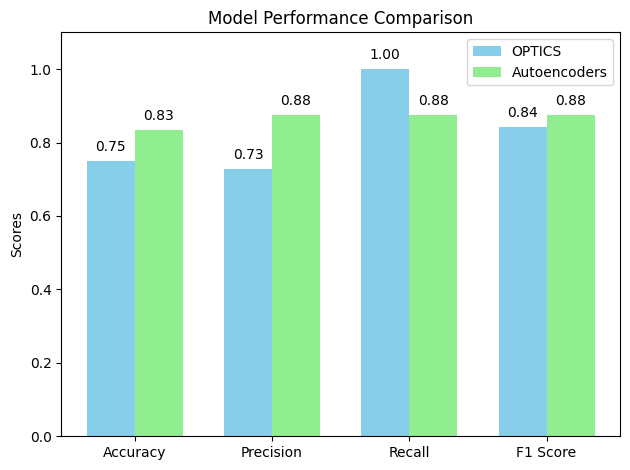

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
optics_scores = [0.75, 0.727, 1.0, 0.841]
ae_scores = [0.833, 0.875, 0.875, 0.875]

x = np.arange(len(metrics))  # label locations
width = 0.35  # bar width

# Plotting
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, optics_scores, width, label='OPTICS', color='skyblue')
rects2 = ax.bar(x + width/2, ae_scores, width, label='Autoencoders', color='lightgreen')

# Labels and titles
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

# Adding bar labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 5),  # offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
